In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Many models

In [2]:
dir = '/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/prune_plateau_early_stop/short_analysis'

In [3]:
# Load metrics and corresponding prune iterations

datas = []
percentages = []

for fname in os.listdir(dir):
    try:
        percentages.append(100 - int(fname[:2]))
    except:
        continue

    data = np.load(os.path.join(dir, fname))
    datas.append(data)

# Add base model
base_metrics = np.load('/glade/derecho/scratch/jshen/2d-turbulence-vit/BASE/base_metrics.npz')
datas.append(base_metrics)
percentages.append(0)
percentages, datas = zip(*sorted(zip(percentages, datas), key=lambda p: p[0]))

norm = mcolors.Normalize(vmin=min(percentages), vmax=max(percentages))

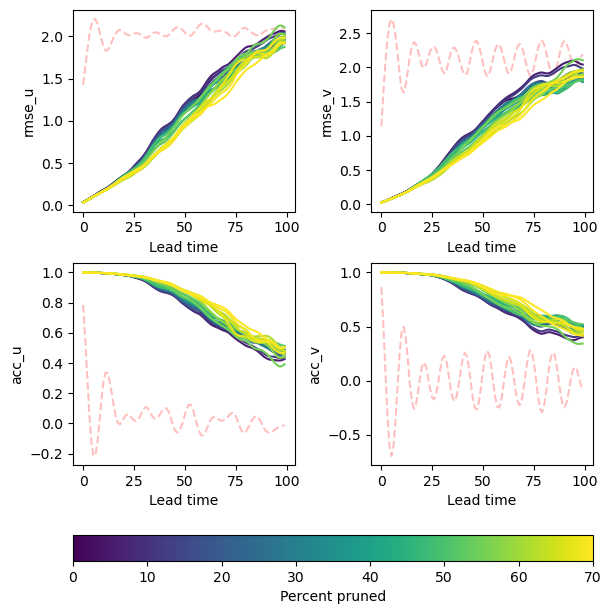

In [4]:

# Metrics to plot

keys = ['rmse_u', 'rmse_v', 'acc_u', 'acc_v']

# Loop thru axs and data

fig, axs = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)
for ax, key in zip(axs.flatten(), keys):

    # Plot persistence
    ax.plot(datas[0][key + '_per'].mean(axis=0), color='r', linestyle='dashed', alpha=0.25)

    # Plot data curves
    for p, data in zip(percentages, datas):
        ax.plot(data[key].mean(axis=0), color=plt.cm.viridis(norm(p)))
    
    ax.set_xlabel('Lead time')
    ax.set_ylabel(key)

# Create color bar

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axs, location='bottom', label="Percent pruned", pad=0.05)

In [5]:
leadtimes = [0, 9, 49, 99]

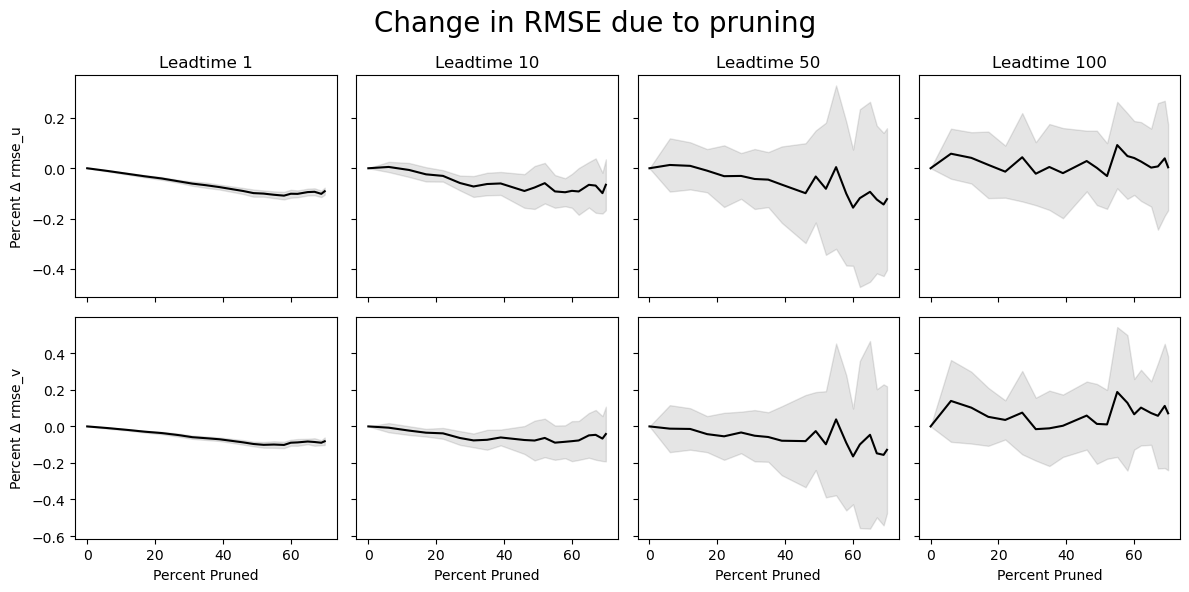

In [6]:
keys        = ['rmse_u', 'rmse_v']

n_metrics   = len(keys)
n_leads     = len(leadtimes)

# 3) Create a 4×4 grid
fig, axes = plt.subplots(
    n_metrics, n_leads,
    figsize=(3*n_leads, 3*n_metrics),
    sharex='col', 
    sharey='row'
)

# 4) Fill in each subplot
for i, key in enumerate(keys):
    for j, t in enumerate( leadtimes):
        ax = axes[i, j]

        deltas = [(d[key][:, t] - base_metrics[key][:, t])/base_metrics[key][:, t] for d in datas]
        
        means = np.array([delta.mean(axis=0) for delta in deltas])
        stds  = np.array([delta.std(axis=0) for delta in deltas])

        ax.plot(percentages, means, color='k')
        ax.fill_between(percentages, means - stds, means + stds, color='k', alpha=0.1)
        
        # only bottom row gets an x-label
        if i == n_metrics - 1:
            ax.set_xlabel('Percent Pruned')

        # only first column gets a y-label
        if j == 0:
            ax.set_ylabel('Percent $\Delta$ ' + key)

        # only top row gets a column title
        if i == 0:
            ax.set_title(f'Leadtime {t+1}')

# 5) Global adjustments
fig.suptitle('Change in RMSE due to pruning', fontsize=20)
fig.tight_layout()

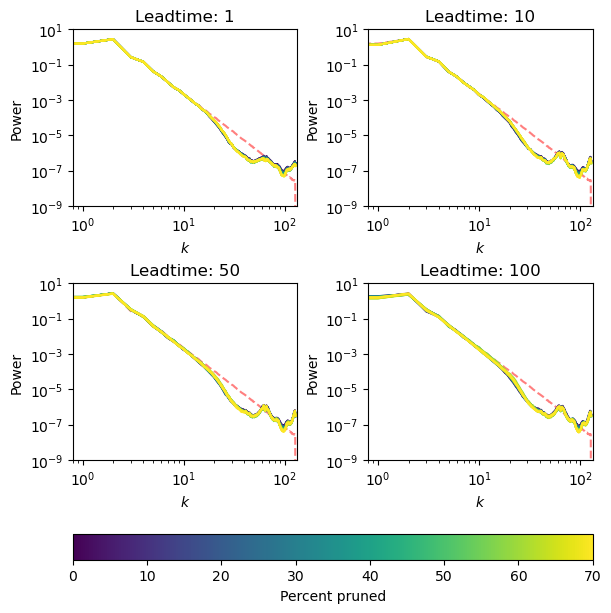

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)
for ax, lead in zip(axs.flatten(), leadtimes):
    ax.plot(data['wavenumbers'], data['spectra_tar'][0], linestyle='dashed', color='r', alpha=0.5)
    for p, data in zip(percentages, datas):
        ax.plot(data['wavenumbers'], data['spectra'][lead], color=plt.cm.viridis(norm(p), alpha=1))
    
    ax.set_title(f'Leadtime: {lead+1}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$k$')
    ax.set_ylabel('Power')
    ax.set_ylim([10**(-9), 10])
    ax.set_xlim([0.8, (256+10)//2])

# Shared colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axs, location='bottom', label="Percent pruned", pad=0.05)